<div align="center">

## Retrieval Augmented Generation(RAG)

</div>

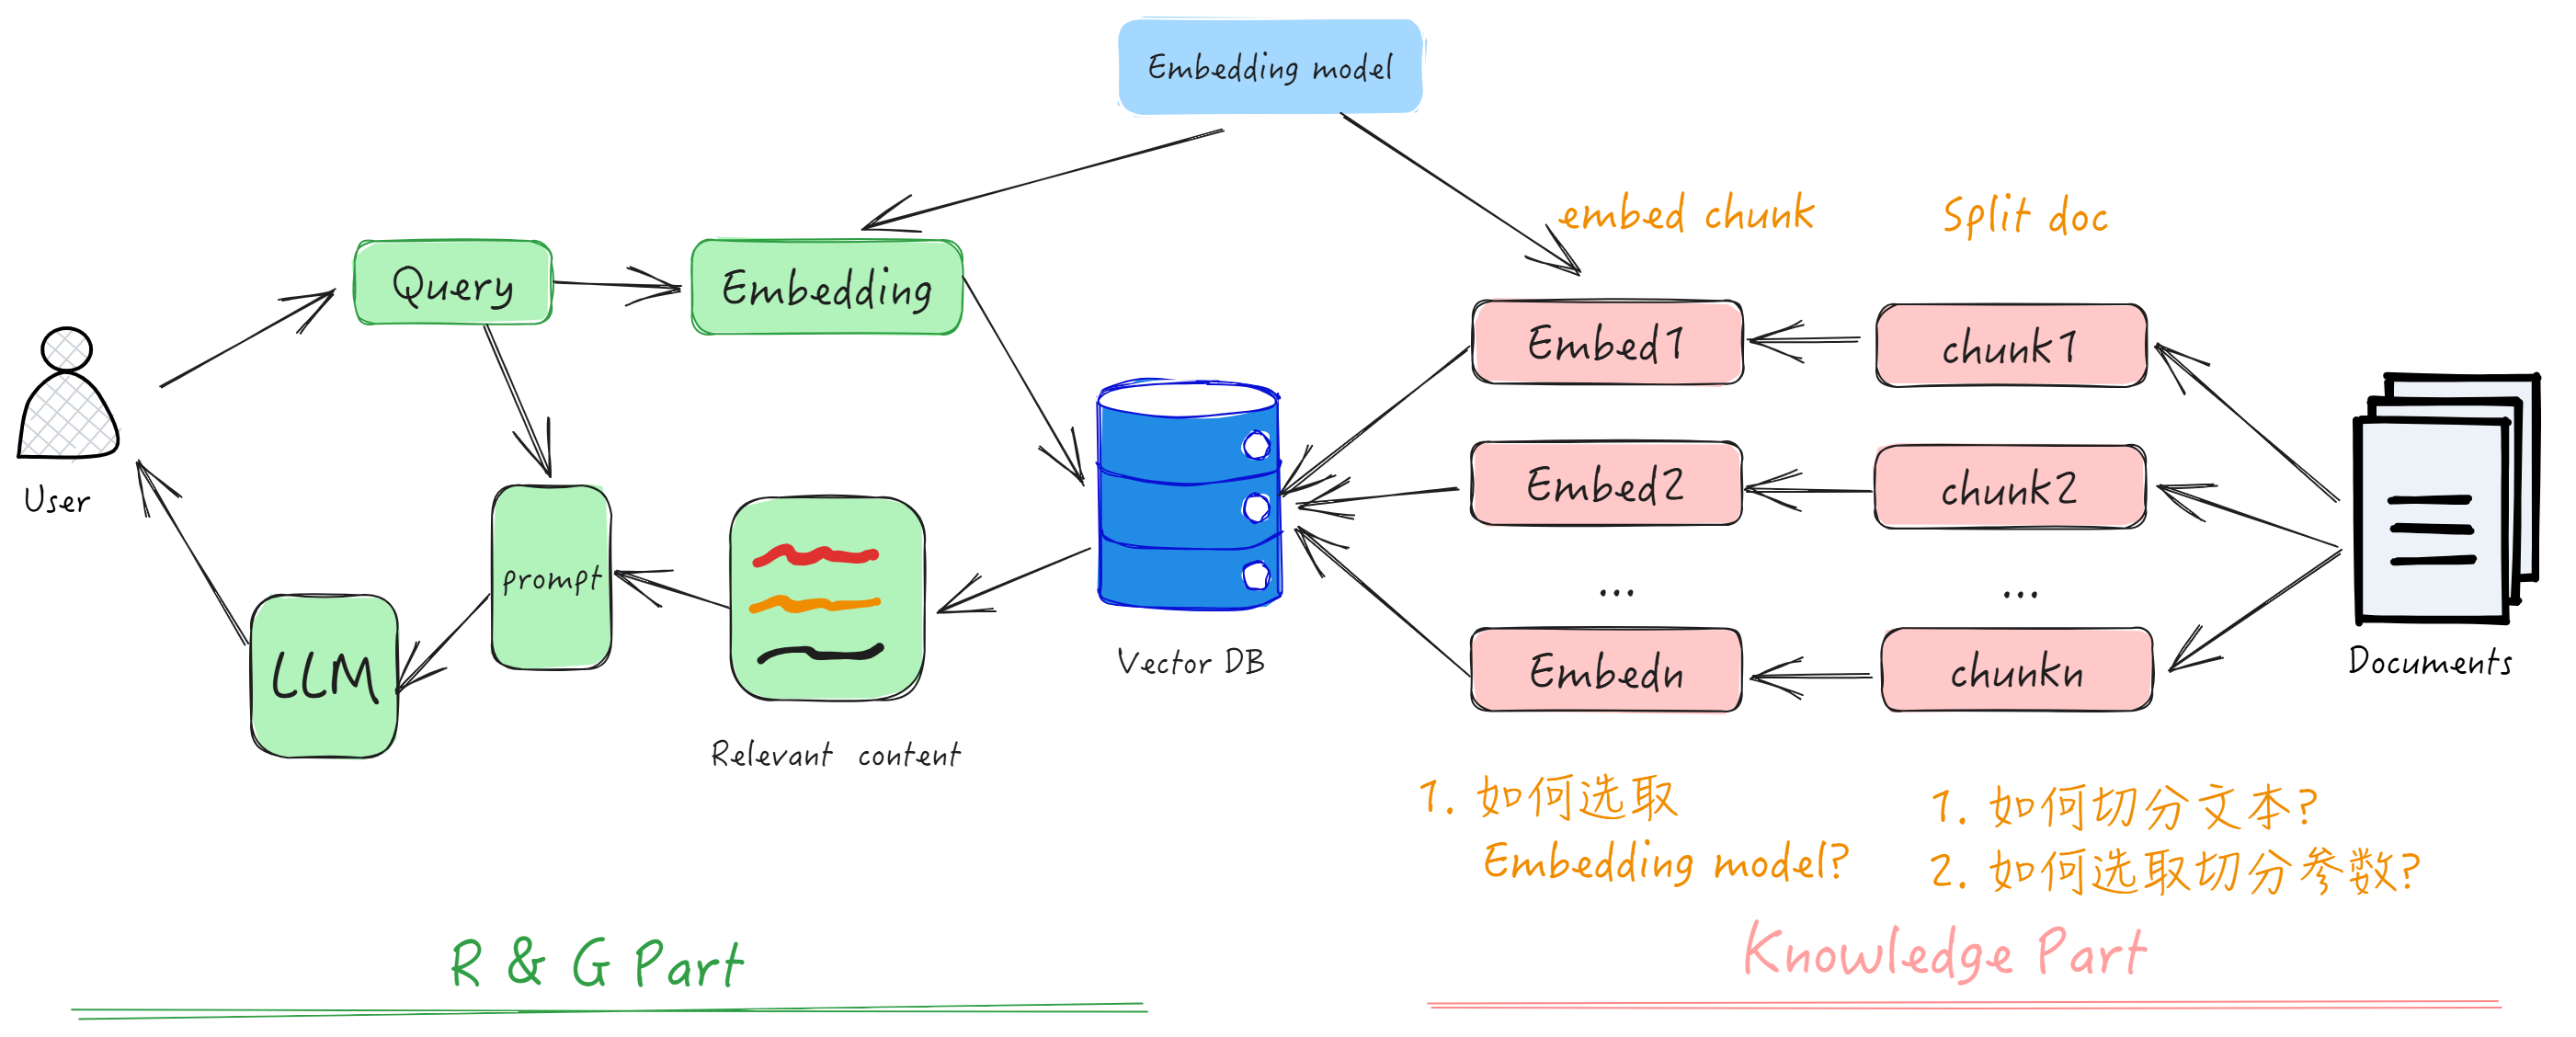


In [1]:
from langchain_community.document_loaders import  PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

## 1. 加载数据 （以deepseek R1论文为例）
[data/DeepSeek_R1.pdf](data/DeepSeek_R1.pdf)

In [2]:
file_path = './data/DeepSeek_R1.pdf'
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

/home/blackink/anaconda3/envs/langchain/lib/python3.10/site-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [3]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=50,
    length_function=len,
)
chunks = text_splitter.split_documents(pages)

In [4]:
embedding_model_name = "/mnt/d/GLNYYGL/GLNYYGL/BAAI/bge-m3"
embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)

/tmp/ipykernel_196497/2706652840.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)
/home/blackink/anaconda3/envs/langchain/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
db_case = Chroma.from_documents(chunks, embeddings ,collection_name='temp' )

query_text= "what is the GRPO?"

relevant_chunks = db_case.similarity_search(query_text , k=5)

In [6]:
context = "\n\n".join([f"Document {i+1}:\n"+"\n"+chunk.page_content for i, chunk in enumerate(relevant_chunks)])

In [7]:
augmented_prompt = f"""请基于所提供的上下文回答问题。
如果上下文中不包含答案，请回答‘对不起，您所提供的上下文中不包含回答问题的信息。’
上下文：
{context}

问题： {query_text}"""

## 不带think的Model —————— deepseek-chat

In [8]:
from openai import OpenAI
import  os
from dotenv import load_dotenv
load_dotenv()

deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")

client = OpenAI(api_key=deepseek_api_key, base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": augmented_prompt},
    ],
    stream=False,
    temperature=0
)

print(response.choices[0].message.content)

GRPO (Group Relative Policy Optimization) 是一种强化学习算法，旨在通过省略通常与策略模型大小相同的评论家模型来节省训练成本。GRPO通过从组分数中估计基线来优化策略模型。具体来说，对于每个问题𝑞，GRPO从旧策略𝜋𝜃𝑜𝑙𝑑中采样一组输出{𝑜1,𝑜2,···,𝑜𝐺}，然后通过最大化以下目标来优化策略模型𝜋𝜃：

\[ J_{GRPO}(\theta) = \mathbb{E}\left[ q \sim P(Q), \{o_i\}_{i=1}^G \sim \pi_{\theta_{old}}(O|q) \right] \frac{1}{G} \sum_{i=1}^G \left[ \min\left( \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)} A_i, \text{clip}\left( \frac{\pi_\theta(o_i|q)}{\pi_{\theta_{old}}(o_i|q)}, 1-\epsilon, 1+\epsilon \right) A_i \right) - \beta D_{KL}(\pi_\theta || \pi_{ref}) \right] \]

其中，𝜀和𝛽是超参数，𝐴𝑖是优势值，通过一组输出来计算。


## 带think的Model————————deepseek-reasoner

In [9]:
response = client.chat.completions.create(
    model="deepseek-reasoner",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": augmented_prompt},
    ],
    stream=False,
    temperature=0
)

print(response.choices[0].message.content)

GRPO (Group Relative Policy Optimization) 是一种强化学习优化方法，旨在降低训练成本。它通过省去传统上需与策略模型相同大小的评论家模型（critic model），转而从组评分（group scores）中估计基线值。具体来说，GRPO 针对每个问题采样一组来自旧策略的输出，并通过最大化包含相对优势剪裁（clipped advantage）和KL散度正则化的目标函数来优化策略模型。该方法由Shao等人在2024年提出，并被应用于提升语言模型的推理能力，例如在无需监督数据的情况下训练模型（如DeepSeek-R1-Zero），促使其自主发展推理技能（如链式思维、自我验证等）。


<div style="display: flex; justify-content: space-between;">
  <div style="width: 45%; padding: 10px; border: 1px solid #ccc;">
    <h3>deepseek-chat</h3>
    <p>GRPO (Group Relative Policy Optimization) 是一种强化学习算法，旨在通过省略通常与策略模型大小相同的评论家模型来节省训练成本。GRPO 通过从组分数中估计基线来优化策略模型。具体来说，对于每个问题，GRPO 从旧策略中采样一组输出，并通过最大化特定目标函数来优化策略模型。GRPO 还使用 KL 散度来约束策略与参考策略之间的差异。
</p>
  </div>
  <div style="width: 45%; padding: 10px; border: 1px solid #ccc;">
    <h3>deepseek-reasoner</h3>
    <p>GRPO（Group Relative Policy Optimization）是一种强化学习算法，由Shao等人在2024年提出。其核心特点是省略了传统强化学习中与策略模型规模相当的**批评模型（critic model）**，转而通过**群体评分（group scores）**估计基线值，从而降低训练成本。具体实现方式包括：

1. **群体采样**：针对每个问题，从旧策略中采样一组输出。
2. **目标函数优化**：通过最大化包含比例剪裁（clipped ratio）和KL散度正则化的目标函数（如公式1和公式2所示），直接优化策略模型。
3. **优势计算**：基于群体输出的相对评分计算优势值，而非依赖独立的批评模型。

该算法被应用于提升语言模型的推理能力（如DeepSeek-R1-Zero项目），无需监督数据，完全通过纯强化学习实现模型性能进化，并在实验中展现出与OpenAI o1系列模型相媲美的推理性能。</p>
  </div>
</div>


<div align="center">

## Retrieval Augmented Generation(RAG)

</div>

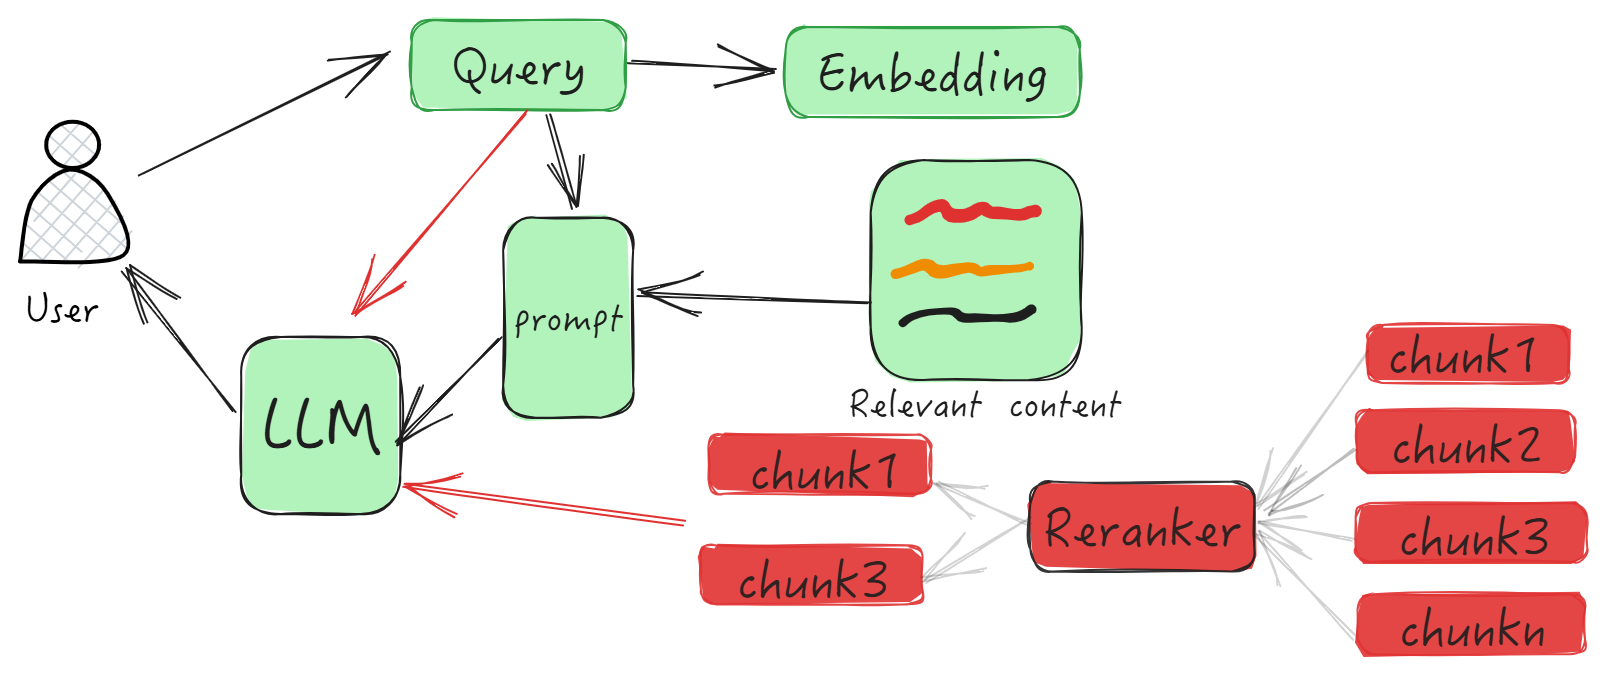
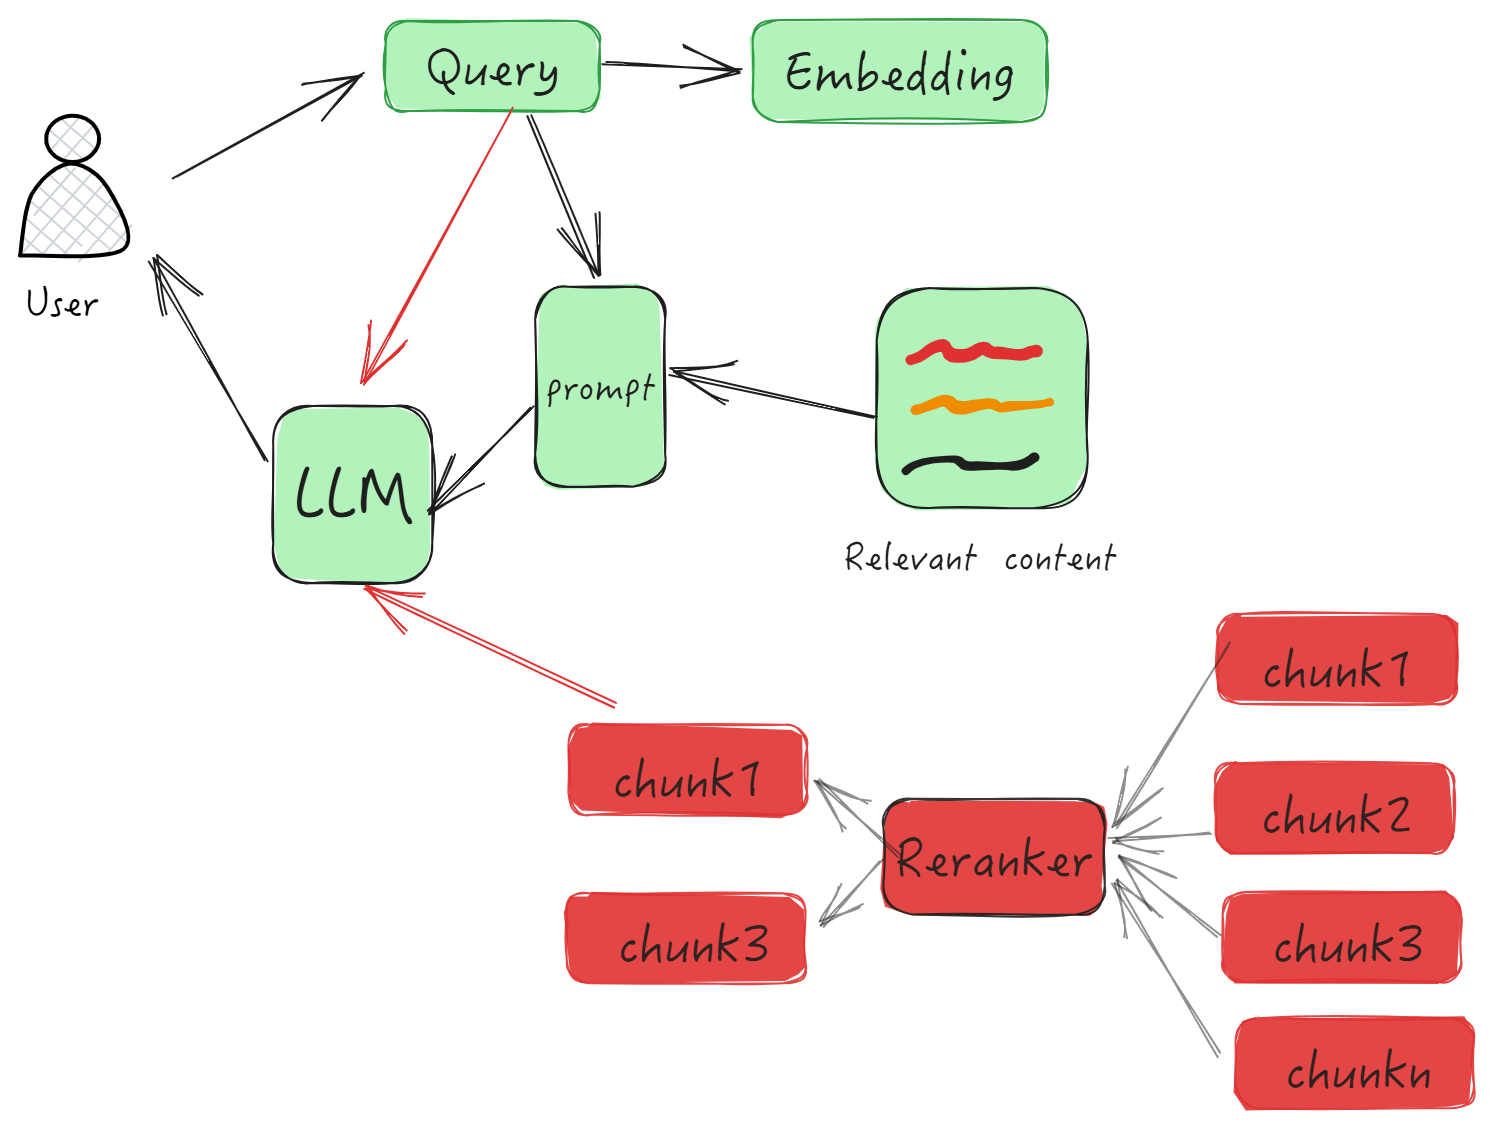

In [10]:
print(context)

Document 1:

brief overview of our RL algorithm, followed by the presentation of some exciting results, and
hope this provides the community with valuable insights.
2.2.1. Reinforcement Learning Algorithm
Group Relative Policy Optimization In order to save the training costs of RL, we adopt Group
Relative Policy Optimization (GRPO) (Shao et al., 2024), which foregoes the critic model that is
typically the same size as the policy model, and estimates the baseline from group scores instead.
Specifically, for each question 𝑞, GRPO samples a group of outputs {𝑜1,𝑜2,···,𝑜𝐺}from the old
policy𝜋𝜃𝑜𝑙𝑑and then optimizes the policy model 𝜋𝜃by maximizing the following objective:
J𝐺𝑅𝑃𝑂(𝜃)=E[𝑞∼𝑃(𝑄),{𝑜𝑖}𝐺
𝑖=1∼𝜋𝜃𝑜𝑙𝑑(𝑂|𝑞)]
1
𝐺𝐺∑︁
𝑖=1
min𝜋𝜃(𝑜𝑖|𝑞)
𝜋𝜃𝑜𝑙𝑑(𝑜𝑖|𝑞)𝐴𝑖, clip𝜋𝜃(𝑜𝑖|𝑞)
𝜋𝜃𝑜𝑙𝑑(𝑜𝑖|𝑞), 1−𝜀, 1+𝜀
𝐴𝑖
−𝛽D𝐾𝐿 
𝜋𝜃||𝜋𝑟𝑒𝑓
,(1)
D𝐾𝐿 
𝜋𝜃||𝜋𝑟𝑒𝑓=𝜋𝑟𝑒𝑓(𝑜𝑖|𝑞)
𝜋𝜃(𝑜𝑖|𝑞)−log𝜋𝑟𝑒𝑓(𝑜𝑖|𝑞)
𝜋𝜃(𝑜𝑖|𝑞)−1, (2)
where𝜀and𝛽are hyper-parameters, and 𝐴𝑖is the advantage, computed using a group of

Document 2:

works have explored

In [11]:
augmented_prompt = f"""请基于所提供的上下文回答问题。

在回答之前，请先分析上下文中的每个文档，并确定它是否包含该问题的答案。
请根据每个文档与问题的相关性进行打分，自动忽略得分非常低(不相关)的文档。
此外，请确保首先列出最相关的文档，然后仅基于这些文档回答问题。

如果上下文中不包含答案，请回答‘对不起，您所提供的上下文中不包含回答问题的信息。’
上下文：
{context}

问题：{query_text}"""


In [12]:
response = client.chat.completions.create(
    model="deepseek-reasoner",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": augmented_prompt},
    ],
    stream=False,
    temperature=0
)

print(response.choices[0].message.content)

**Relevant Documents and Scores:**  
1. **Document 1 (Score: 10/10)**: Directly explains GRPO’s technical details, including its objective function and methodology.  
2. **Document 2 (Score: 8/10)**: Mentions GRPO as the RL framework used to improve reasoning in DeepSeek-R1-Zero but lacks technical specifics.  
3. **Documents 3–5 (Score: 0/10)**: No relevance to GRPO.  

---

**Answer:**  
**GRPO (Group Relative Policy Optimization)**, proposed by Shao et al. (2024), is a reinforcement learning (RL) algorithm designed to reduce training costs by eliminating the need for a separate critic model. Instead of using a critic, GRPO estimates advantages using **group scores** from sampled outputs.  

Key features:  
1. For each question \( q \), it samples a group of outputs \( \{o_1, o_2, \dots, o_G\} \) from an old policy \( \pi_{\theta_{\text{old}}} \).  
2. It optimizes the policy model \( \pi_{\theta} \) by maximizing a clipped objective (similar to PPO) that balances reward maximization

In [13]:
reasoning_content = response.choices[0].message.reasoning_content
content = response.choices[0].message.content

In [14]:
print(reasoning_content)

好的，我现在要回答用户的问题：“what is the GRPO?”，也就是要解释GRPO是什么。首先，我需要仔细阅读用户提供的所有文档，看看哪些文档提到了GRPO，并评估它们与问题的相关性。

首先看Document 1，里面提到了Group Relative Policy Optimization (GRPO)，并且详细描述了它的算法和目标函数，包括如何通过采样输出来优化策略模型，省去了critic模型的使用。这个文档看起来非常相关，应该得分最高。

接下来是Document 2，这里提到他们使用GRPO作为强化学习的框架，来提升模型的推理能力，但没有具体解释GRPO是什么，所以相关性次之，可能作为支持信息。

Document 3没有提到GRPO，主要讨论的是MCTS和其他方法，相关性低。Document 4和5也没有提到GRPO的具体定义，虽然Document 5提到了RL的应用，但没有涉及GRPO的细节。因此，这些文档的得分较低，可以忽略。

所以，最相关的文档是Document 1和Document 2。结合这两个文档的信息，GRPO是Group Relative Policy Optimization的缩写，由Shao等人在2024年提出。它是一种强化学习算法，旨在减少训练成本，通过放弃通常与策略模型大小相同的critic模型，转而使用组内分数来估计基线。具体来说，对于每个问题，GRPO从旧策略中采样一组输出，然后通过最大化特定的目标函数来优化策略模型，其中包括优势函数和KL散度的正则化项，以平衡策略更新和参考策略的偏离。

因此，回答应基于Document 1的详细说明，并结合Document 2中提到的应用背景来阐述GRPO的作用和目的。
